In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import os #For directory and file operations
import numpy as np#For numerical operations and handling image arrays
import random #For generating random values for augemntation
from PIL import Image, ImageEnhance #For image processing enhancement
from tensorflow.keras.preprocessing.image import load_img # for image loading
from tensorflow.keras.models import Sequential # for building model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout # for model layer
from tensorflow.keras.optimizers import Adam # for optimizer
from tensorflow.keras.applications import VGG16 # for using VGG16 model
from sklearn.utils import shuffle #for shuffling the data

# Load Dataset

In [46]:
#Directories for training and testing data
train_dir= '/content/drive/MyDrive/MRI Images/Training'
test_dir= '/content/drive/MyDrive/MRI Images/Testing'

#load and shuffle the train data
train_paths= []
train_labels= []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels= shuffle(train_paths, train_labels)

test_paths= []
test_labels= []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels= shuffle(train_paths, train_labels)

# Data Visualization

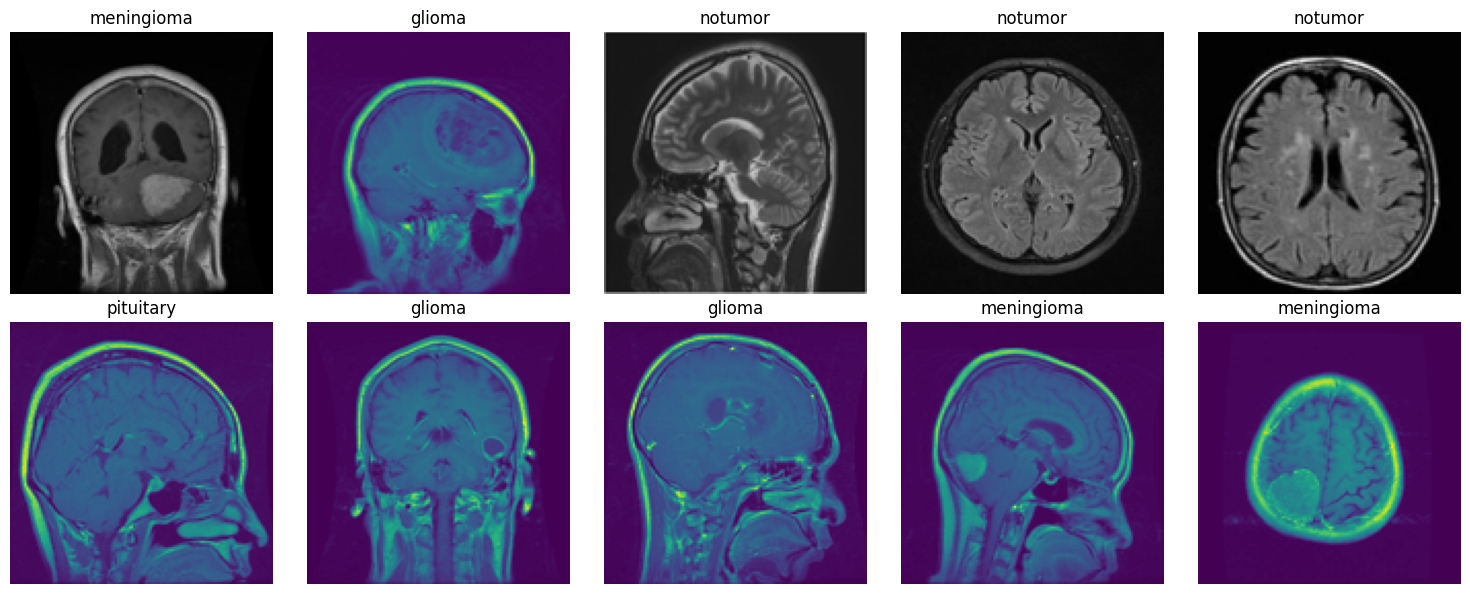

In [4]:
import matplotlib.pyplot as plt

#Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)),10)

#Create a figure to display images in 2 rows
fig, axes= plt.subplots(2,5, figsize=(15,6))
axes= axes.ravel()

#Loop through the random indices and display images
for i, idx in enumerate(random_indices):
  img_path= train_paths[idx]
  img= Image.open(img_path)
  img= img.resize((128,128))

  #Display images
  axes[i].imshow(img)
  axes[i].set_title(train_labels[idx])
  axes[i].axis('off')

plt.tight_layout()
plt.show()

# Image Preprocessing

In [5]:
#Image Augmentation Function
def augment_image(image):
  image= Image.fromarray(np.uint8(image))
  image= ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image= ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image= ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))

  image= np.array(image)/255.0
  return image

#Load Images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
    img= load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img= augment_image(img)
    images.append(img)
  return np.array(images)

#Encoder labels (Convert label names to integer)
def encode_label(labels):
  unique_labels= sorted(os.listdir(train_dir))
  encoded= [unique_labels.index(label) for label in labels]
  return np.array(encoded)

#Data generator for batching
def datagen(paths, labels, batch_size=12 ,epochs=1):
  for _ in range (epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths= paths[i: i+batch_size]
      batch_images= open_images(batch_paths)
      batch_labels= labels[i:i + batch_size]
      batch_labels= encode_label(batch_labels)
      yield batch_images, batch_labels

# Model
VGG16


In [6]:
len(os.listdir(train_dir))

4

In [16]:
#Model Architecture (128,128,3)
IMAGE_SIZE= 128
base_model= VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights= 'imagenet' )

#Freeze all layers of VGG16 base model
for layer in base_model.layers:
  layer.trainable= False

#Set only the last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

#Build model
model= Sequential()
model.add(Input(shape= (IMAGE_SIZE, IMAGE_SIZE, 3))) #Input Layer
model.add(base_model) #VGG16 model
model.add(Flatten()) #Flatten
model.add(Dropout(0.3)) #Dropout Layer
model.add(Dense(128, activation='relu')) #Dense Layer
model.add(Dropout(0.2)) #Dropout layer
model.add(Dense(len(os.listdir(train_dir)),activation= 'softmax')) #Output layer

#Compile the model
model.compile(optimizer= Adam(learning_rate= 0.0001), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

#Parameters
batch_size= 20
steps= int(len(train_paths) / batch_size)
epochs= 5

#Train model
history= model.fit(
    datagen(train_paths, train_labels, batch_size= batch_size, epochs= epochs),
    epochs= epochs, steps_per_epoch= steps
)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1238s 4s/step - accuracy: 0.7339 - loss: 0.6938
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1228s 4s/step - accuracy: 0.9000 - loss: 0.2485
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1228s 4s/step - accuracy: 0.9272 - loss: 0.1798
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1227s 4s/step - accuracy: 0.9604 - loss: 0.1133
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1227s 4s/step - accuracy: 0.9738 - loss: 0.0746


In [17]:
model.save('/content/drive/MyDrive/mri_model.keras')

In [47]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/mri_model.keras', compile=False)


In [48]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


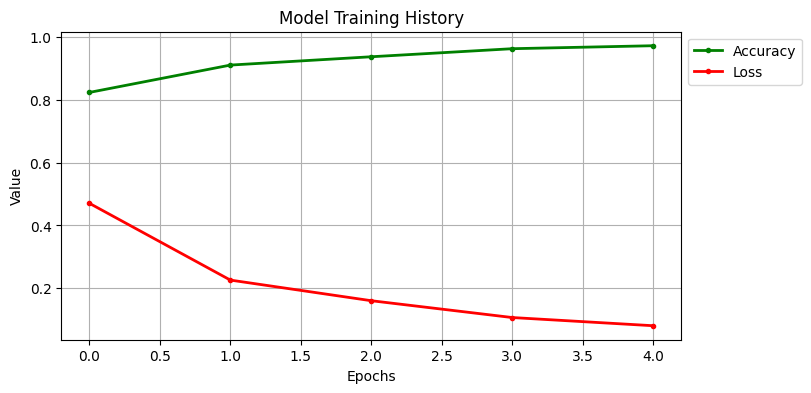

In [20]:
plt.figure(figsize=(8,4))
plt.grid(True)

plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)

plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


##Model Classification Report

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images= open_images(test_paths)
test_labels= encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report: ")
print(classification_report(test_labels, np.argmax(test_predictions, axis=1)))



179/179 ━━━━━━━━━━━━━━━━━━━━ 1154s 6s/step
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1321
           1       0.94      0.98      0.96      1339
           2       1.00      0.99      0.99      1595
           3       0.96      1.00      0.98      1457

    accuracy                           0.97      5712
   macro avg       0.97      0.97      0.97      5712
weighted avg       0.98      0.97      0.97      5712



##Model Confusion Plot

Confussion Matrix: 
[[1224   80    0   17]
 [   0 1308    2   29]
 [   0    7 1577   11]
 [   0    1    0 1456]]


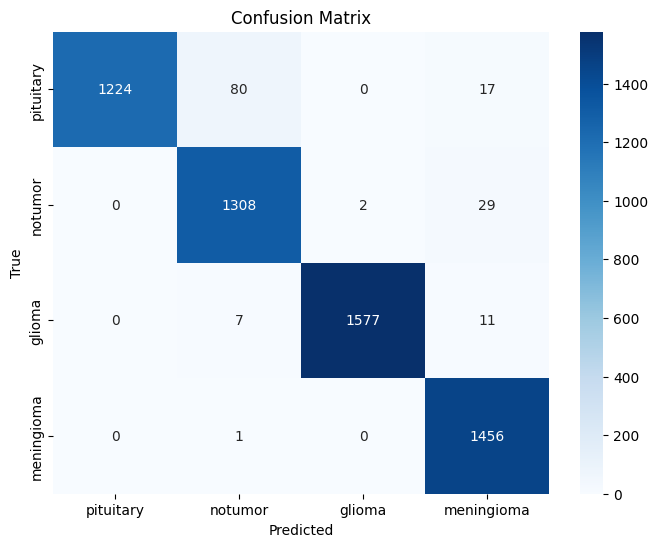

In [23]:
conf_matrix= confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))
print("Confussion Matrix: ")
print(conf_matrix)

plt.figure(figsize= (8,6))
sns.heatmap( conf_matrix, annot= True, fmt= 'd', cmap= 'Blues', xticklabels= os.listdir(train_dir), yticklabels= os.listdir(train_dir))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


##RocCurvePlot

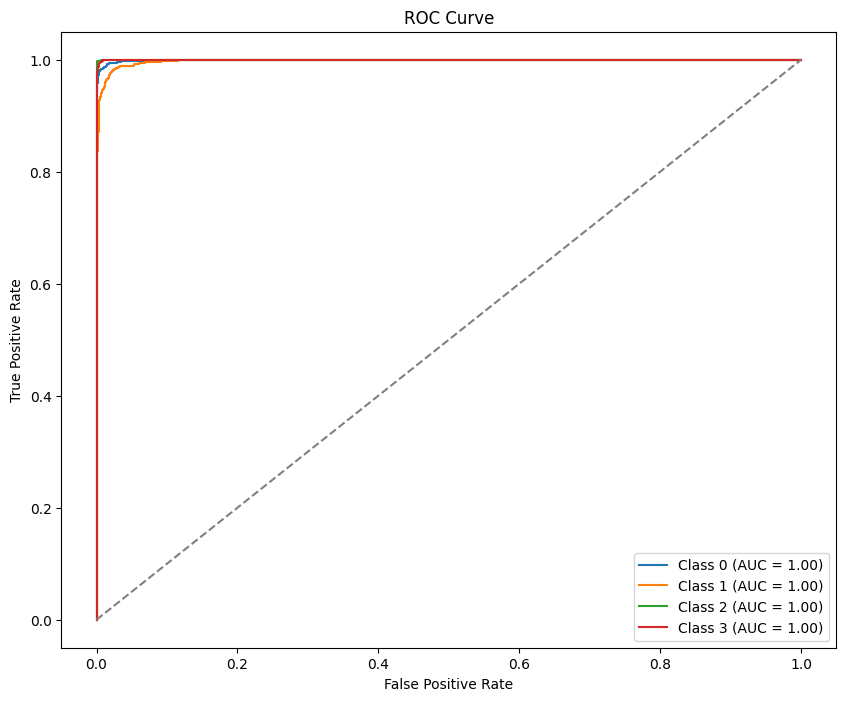

In [29]:
#4. ROC Curve and AUC
#Binarize the test labels and predictions for multi-class ROC
test_labels_bin= label_binarize(test_labels, classes= np.arange(len(os.listdir(train_dir))))
test_predictions_bin= test_predictions #the predicted probabilities for each class

#Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc= {}, {}, {}
for i in range(len(os.listdir(train_dir))):
  fpr[i], tpr[i], _= roc_curve(test_labels_bin[:,i], test_predictions_bin[:,i])
  roc_auc[i]= auc(fpr[i], tpr[i])

#Plot ROC curve
plt.figure(figsize=(10,8))
for i in range(len(os.listdir(train_dir))):
  plt.plot(fpr[i], tpr[i], label= f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], linestyle= '--', color='grey') #Diagnol Line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc= 'lower right')
plt.show()

#The graph shows, if the curve is above the 45 degree straight line it is well trained otherwise it is not trained well

In [50]:
#Save the entire model
model.save('model.keras')

In [51]:
from tensorflow.keras.models import load_model
#Load the trained model
model = load_model('model.keras')

##MRI Tumor Detection System

In [52]:
from keras.preprocessing.image import load_img, img_to_array

class_labels=['pitutary', 'glioma', 'notumor', 'meningioma']
def detect_and_display(image_path, model):
  try:
    #Load Image
    img= load_img(img_path, target_size=(128,128))
    img_array= img_to_array(img)
    img_array= np.expand_dims(img_array, axis=0)

    #Prediction
    predictions= model.predict(img_array) # 0= 0.90, 1= 0.60, 2= 0.99, 3= 0.40
    predicted_class_index= np.argmax(predictions)
    confidence= np.max(predictions, axis=1)[0]

    #Determine the class
    if class_labels[predicted_class_index] == 'notumor':
      result= "No Tumor Detected"
    else:
      result= f"Tumor: {class_labels[predicted_class_index]} Detected"


    #Display Image
    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f'Prediction: {result}\nConfidence: {confidence * 100:.2f}%')

  except Exception as e:
    print("Error processing the image", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


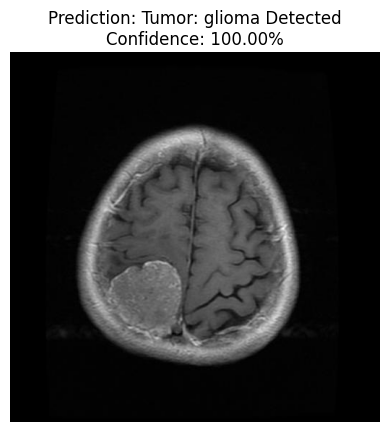

In [53]:
#Example usage
image_path= '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0000.jpg' #Provide the path of the image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


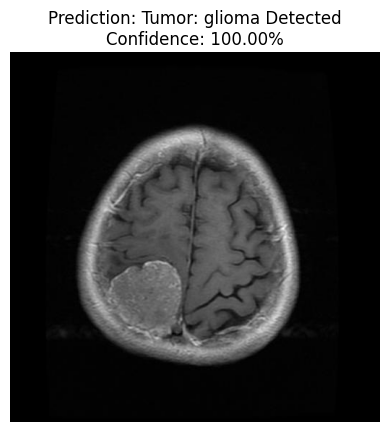

In [42]:
#Example usage
image_path= '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0003.jpg' #Provide the
detect_and_display(image_path, model)

In [55]:
model.save('/content/drive/MyDrive/mri_model.keras')
model.save('/content/drive/MyDrive/mri_model.h5')